# Task 4: Manual Homography + Sticthing

## 1. Supporting Functions:

In [1]:
import numpy as np
import scipy.linalg as linalg
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def getHomography(x1, x2, x3, x4, y1, y2, y3, y4):
    print(x1, x2, x3, x4, y1, y2, y3, y4)
    A = np.array([[x1[0],x1[1],1, 0,0,0, -x1[0]*y1[0],-x1[1]*y1[0],-y1[0]],
                  [0,0,0, x1[0],x1[1],1, -x1[0]*y1[1],-x1[1]*y1[1],-y1[1]],
                  [x2[0],x2[1],1, 0,0,0, -x2[0]*y2[0],-x2[1]*y2[0],-y2[0]],
                  [0,0,0, x2[0],x2[1],1, -x2[0]*y2[1],-x2[1]*y2[1],-y2[1]],
                  [x3[0],x3[1],1, 0,0,0, -x3[0]*y3[0],-x3[1]*y3[0],-y3[0]],
                  [0,0,0, x3[0],x3[1],1, -x3[0]*y3[1],-x3[1]*y3[1],-y3[1]],
                  [x4[0],x4[1],1, 0,0,0, -x4[0]*y4[0],-x4[1]*y4[0],-y4[0]],
                  [0,0,0, x4[0],x4[1],1, -x4[0]*y4[1],-x4[1]*y4[1],-y4[1]]])
#     print(A)
    U, D, Vt = linalg.svd(A)
    H = Vt[-1].reshape(3,3)
#     print(H)
    
    return H

In [3]:
%matplotlib tk
def choosePoints(img1, img2):

    matplotlib.use('TkAgg')

    imshow(img1, interpolation='none')
    chosenPoints1 = ginput(4) 
    print(chosenPoints1)
    
    imshow(img2, interpolation='none')
    chosenPoints2 = ginput(4) 
    print(chosenPoints2)
    
    return chosenPoints1, chosenPoints2

In [4]:
def getMinMax(array):
    print("getMinMax:")
    print(array[0,:])
    print("getMinMaxEnd")
    minX = np.min(array[0,:])
    minY = np.min(array[1,:])
    maxX = np.max(array[0,:])
    maxY = np.max(array[1,:])
    return minX, minY, maxX, maxY

In [5]:
def computeHomographyAndConcat1(img1, img2):
    imgSizeX1 = img1.shape[0]
    imgSizeY1 = img1.shape[1]
    imgSizeX2 = img2.shape[0]
    imgSizeY2 = img2.shape[1]
    
    # read the chosen points:
    chosenPts1, chosenPts2 = choosePoints(img1, img2)
    
    H = getHomography(chosenPts1[0], chosenPts1[1], chosenPts1[2], chosenPts1[3],
                      chosenPts2[0], chosenPts2[1], chosenPts2[2], chosenPts2[3])
    
    # get the orgPoses as an array of size 3*imgSize not an img:
    i, cnt= 0, 0
    step = 0.5
    newPos = np.zeros((3,int(imgSizeX1/step)*int(imgSizeY1/step)))
    while(i < imgSizeY1):
        j=0
        while(j < imgSizeX1):
            newPos[:,cnt] = H.dot(np.array([i,j,1]))
            newPos[:,cnt] = newPos[:,cnt]/newPos[2,cnt]
            newPos[0,cnt] = newPos[0,cnt]
            newPos[1,cnt] = newPos[1,cnt]
            j+=step
            cnt+=1
        i+=step
    # get the minimum and maximum poses of the orgPoses
    minX, minY, maxX, maxY = getMinMax(newPos)
    print(minX, minY, maxX, maxY)
    # shifting img1, shifting the maximum size of the canvas
    shiftX = 0
    shiftY = 0
    if minX < 0:
        newPos[0,:] += abs(minX)
        shiftX = int(abs(minX))
        maxX += abs(minX)
    if minY < 0:
        newPos[1,:] += abs(minY)
        shiftY = int(abs(minY))
        maxY += abs(minY)
    # get the new canvas
    newSizeX = int(maxX)+imgSizeX2
    newSizeY = int(maxY)+imgSizeY2
    newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
    # prepare img2 on the new canvas
    for i in range(0,int(imgSizeX2)):
        for j in range(0,int(imgSizeY2)):
            newImg[i+shiftY][j+shiftX] = img2[i][j]
    # loop to prepare img1 on the new canvas   
    i, cnt= 0, 0
    step = 0.5
    while(i < imgSizeY1):
        j=0
        while(j < imgSizeX1):
            newPosX = int(newPos[0][cnt]) # round the indexes to integer
            newPosY = int(newPos[1][cnt])
            if((newPosX >= 0 and newPosX < newSizeY) and (newPosY >= 0 and newPosY < newSizeX)):
                newImg[newPosY][newPosX] = img1[int(j)][int(i)]
            j+=step
            cnt+=1
        i+=step            
    # Draw img
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.imshow(newImg/255)
    plt.show()

## 2. Stitch the Image

[(22.545527206294537, 282.3441528784073), (284.82209512341973, 282.7427494861841), (17.36377130519628, 397.5385725258984), (265.2908613423571, 421.0557723847288)]
[(323.0873694699912, 259.62414623513047), (573.0074425460359, 260.42133945068406), (323.48596607776796, 333.76311528161267), (556.6649816271877, 370.83259980485377)]
(22.545527206294537, 282.3441528784073) (284.82209512341973, 282.7427494861841) (17.36377130519628, 397.5385725258984) (265.2908613423571, 421.0557723847288) (323.0873694699912, 259.62414623513047) (573.0074425460359, 260.42133945068406) (323.48596607776796, 333.76311528161267) (556.6649816271877, 370.83259980485377)
getMinMax:
[ 295.96138449  295.97970439  295.9980244  ... 1244.42951804 1244.47128379
 1244.51305002]
getMinMaxEnd
295.9613844929546 -91.00058164195835 1244.5130500220225 508.73236742584334


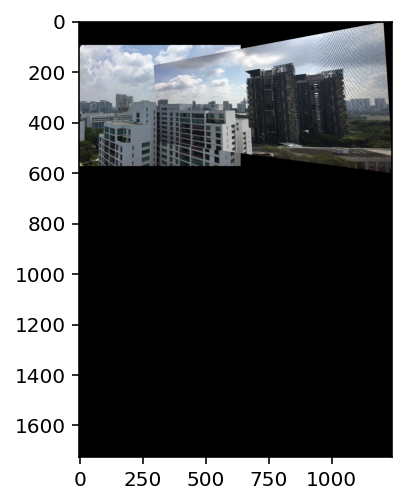

In [6]:
# Testing block
img1 = cv2.imread('im01.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('im02.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
computeHomographyAndConcat1(img2, img1)

## 3. Explaination of the Double Edges Effect:

There are four factors that might contribute to the double edges effect if the images are blended together.  
The first one is that the manually selected points are not exactly matching pairs. This is to say that the a pair of points on two sides selected by a human being are not depicting the same real-world point. Thus, the homography matrix computed by the inaccurate pairs cannot transform one image to the exact same copy as the other one.  

The second possible reason is that the two images are not describing the exactly same scenes. It is obvious that the two images includes the same white building at the very front. But they also includes something else, such as the clouds at the back. The shape and position of the clouds may change very much in seconds or minites, so the images will have clouds of double edges at the overlapped areas.  

The third reason for this is that four pairs of points might be too little to match the whole building. If we choose the four pairs of points at the four coners of the white building in the front, then the four coners should overlap after transformation. But the other details, such as the coners of each window of the buildings may not match each other perfectly.  

Finally, the pairs that is chosen by human beings might not describe the best plane to match. This creates in-perfect matches and thus double edges. 

In [7]:
# # Testing block:
# array = np.array([[1,-1,-10,9,8],[3,101,-9,0,7],[1,2,3,4,5]])
# getMinMax(array)

In [8]:
# def computeHomographyAndConcat(img1, img2):
#     imgSizeX1 = img1.shape[0]
#     imgSizeY1 = img1.shape[1]
#     imgSizeX2 = img2.shape[0]
#     imgSizeY2 = img2.shape[1]
    
#     # read the chosen points:
#     chosenPts1, chosenPts2 = choosePoints(img1, img2)
    
#     H = getHomography(chosenPts1[0], chosenPts1[1], chosenPts1[2], chosenPts1[3],
#                       chosenPts2[0], chosenPts2[1], chosenPts2[2], chosenPts2[3])
#     HInverse = np.linalg.pinv(H)
    
#     # get the orgPoses as an array of size 3*imgSize not an img:
#     arrOrgPos = np.zeros((3,imgSizeX1*imgSizeY1))
#     cnt = 0
#     for i in range(0, imgSizeX1):
#         for j in range(0, imgSizeX1):
#             arrOrgPos[:,cnt] = HInverse.dot(np.array([i,j,1]))
#             arrOrgPos[:,cnt] = arrOrgPos[:,cnt]/arrOrgPos[2,cnt]
#             arrOrgPos[0,cnt] = int(arrOrgPos[0,cnt])
#             arrOrgPos[1,cnt] = int(arrOrgPos[1,cnt])
# #             print(arrOrgPos[0,cnt],arrOrgPos[1,cnt],arrOrgPos[2,cnt])
#             cnt+=1
#     # get the minimum and maximum poses of the orgPoses
#     minX, minY, maxX, maxY = getMinMax(arrOrgPos)
#     print(minX, minY, maxX, maxY)
#     # shifting img1, shifting the maximum size of the canvas
#     shiftX = 0
#     shiftY = 0
#     if minX < 0:
#         arrOrgPos[0,:] += abs(minX)
#         shiftX = int(abs(minX))
#         maxX += abs(minX)
#     if minY < 0:
#         arrOrgPos[1,:] += abs(minY)
#         shiftY = int(abs(minY))
#         maxY += abs(minY)
#     # get the new canvas
#     newSizeX = int(maxX)+imgSizeX2
#     newSizeY = int(maxY)+imgSizeY2
#     newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
#     # prepare img2 on the new canvas
#     for i in range(0,int(imgSizeX2)):
#         for j in range(0,int(imgSizeY2)):
#             newImg[i+shiftX][j+shiftY] = img2[i][j]   
    
#     for i in range(0, newSizeY):
#         for j in range(0, newSizeX):
#             newPos = np.array([i, j, 1])
#             orgPos = HInverse.dot(newPos) # find the corresponding indexes in the original image by H^(-1)
#             orgPos = orgPos/orgPos[2] # normalize the indexes
#             orgPosX = int(orgPos[0]) # round the indexes to integer
#             orgPosY = int(orgPos[1]) 
#             if((orgPosX >= 0 and orgPosX < imgSizeY1) and (orgPosY >= 0 and orgPosY < imgSizeX1)):
#                 if(j+shiftX < newSizeX and i+shiftY < newSizeY):
#                     newImg[j+shiftX][i+shiftY] = img1[orgPosY][orgPosX]       
                
#     # Draw img
#     %matplotlib inline
#     %config InlineBackend.figure_format = 'retina'
#     plt.imshow(newImg/255)
#     plt.show()

In [9]:
# # Testing block
# img1 = cv2.imread('im01.jpg')
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.imread('im02.jpg')
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# computeHomographyAndConcat(img2, img1)